<a href="https://colab.research.google.com/github/sayarghoshroy/Linear-Programming-Problems/blob/master/LPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Programming

### Applications of linear programming in real life problems ranging from classical physics to logical puzzles.

#### The problem formulations are provided and the solutions are implemented using `cvxpy`

## Problems 
1. Sudoku
2. Best Polyhedron
3. Largest Ball
4. Illumination Problem
5. Jigsaw Puzzle

#### Note: Run Cells One by One, 'run all' gives some issues at times

In [1]:
# Installing dependencies
# Uncomment if requirements are not satisfied
# !pip3 install numpy==1.18.1 matplotlib==3.1.3 scipy==1.4.1 sklearn
# !pip3 install cvxpy==1.0.25 scikit-image==0.16.2

In [2]:
# For Compatibility
from __future__ import print_function, division

import os 
import sys
import random
import numpy as np 
import cvxpy as cp 
import matplotlib.pyplot as plt 

# Problem Specific Modules 
from sklearn.datasets import make_circles # Best Polyhedron
from scipy.spatial import ConvexHull # Largest Ball in Polyhedron
from scipy.linalg import null_space # Illumination
import matplotlib.cbook as cbook # Jigsaw
from skimage.transform import resize # Jigsaw
% matplotlib inline

## Sudoku

- Formulating a mixed integer programming algorithm based on branch and bound to solve Sudoku puzzles.

The function takes as input a Sudoku puzzle as a $9 \times 9$ list-of-lists of integers:


    puzzle = [[4, 8, 0, 3, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 7, 1],
              [0, 2, 0, 0, 0, 0, 0, 0, 0],
              [7, 0, 5, 0, 0, 0, 0, 6, 0],
              [0, 0, 0, 2, 0, 0, 8, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 7, 6, 0, 0, 0],
              [3, 0, 0, 0, 0, 0, 4, 0, 0],
              [0, 0, 0, 0, 5, 0, 0, 0, 0]]

- Zeros represent missing entries that must be assigned by the algorithm, and all other integers represent a known assignment. 

- The class `SudokuSolver` inherits the `Sudoku` class. The function `plot` is used to plot the unsolved and solved puzzles. The function `solve` gets the unsolved puzzle as the input and returns the solution as a $9 \times 9$ numpy array.

    
    solved_puzzle = [[4, 8, 7, 3, 1, 2, 6, 9, 5],
                     [5, 9, 3, 6, 8, 4, 2, 7, 1],
                     [1, 2, 6, 5, 9, 7, 3, 8, 4],
                     [7, 3, 5, 8, 4, 9, 1, 6, 2],
                     [9, 1, 4, 2, 6, 5, 8, 3, 7],
                     [2, 6, 8, 7, 3, 1, 5, 4, 9],
                     [8, 5, 1, 4, 7, 6, 9, 2, 3],
                     [3, 7, 9, 1, 2, 8, 4, 5, 6],
                     [6, 4, 2, 9, 5, 3, 7, 1, 8]]

In [3]:
# Class Sudoku generates new sudoku problems
class Sudoku():
  def __init__(self):
    super(Sudoku,self).__init__()
    self.puzzle = None
    # Unsolved Sudoku Puzzle 
    self.solution = None
    pass

  def construct_solution(self):
    while True:
      # until a solved sudoku puzzle is created
      puzzle = np.zeros((9,9))
      rows    = [set(range(1,10)) for i in range(9)]
      columns = [set(range(1,10)) for i in range(9)]
      squares = [set(range(1,10)) for i in range(9)]
      # set of available numbers for each row, column and square
      try:
        for i in range(9):
          for j in range(9):
            choices = rows[i].intersection(columns[j]).intersection(squares[(i//3)*3 + j//3])
            choice  = random.choice(list(choices))

            puzzle[i,j] = choice
            # updating the puzzle
            
            rows[i].discard(choice) 
            columns[j].discard(choice)
            squares[(i // 3) * 3 + j // 3].discard(choice)

        return puzzle

      except IndexError:
        # to start over in case of a dead end
        continue 
      
  def construct_problem(self, solution, n = 28):
    def canBeDeduced(puz, i, j, c):
      # to check if the cell value can be deduced from the remaining cells 
      v = puz[c // 9, c % 9]
      if puz[i, j] == v:
        return True
      if puz[i, j] in range(1, 10):
        return False
        
      for m in range(9):
        # testing across row, column, and square
        # if another cell in the group contains the value 'v', then "False"
        if not (m ==c // 9 and j == c%9) and puz[m, j] == v:
          return False
        if not (i == c // 9 and m == c % 9) and puz[i, m] == v:
          return False
        if not ((i // 3) * 3 + m // 3 ==c // 9 and (j // 3) * 3 + m % 3 == c % 9) and puz[(i // 3) * 3 + m // 3, (j // 3) * 3 + m % 3] == v:
          return False
      return True

    cells = set(range(81))	
    cellsLeft = set(range(81))

    while len(cells) > n and len(cellsLeft):
      cell = random.choice(list(cellsLeft))
      # choose a random cell
      cellsLeft.discard(cell)

      # recording whether another cell in the set could also take on the plucked value
      
      row = col = square = False  

      for i in range(9):
        if i != cell/9:
          if canBeDeduced(solution, i, cell%9, cell):
            row = True
        if i != cell % 9:
          if canBeDeduced(solution, cell//9, i, cell):
            col = True
        if not (((cell // 9) // 3) * 3 + i // 3 == cell // 9 and ((cell // 9) % 3) * 3 + i % 3 == cell % 9):
          if canBeDeduced(solution, ((cell // 9) // 3) * 3 + i // 3, ((cell // 9) % 3) * 3 + i % 3, cell):
            square = True

      if row and col and square:
        continue
      else:
        # the cell is pluckable
        solution[cell // 9][cell % 9] = 0
        cells.discard(cell)
        # we don't need to reset "cellsLeft":
        # if a cell was not pluckable earlier
        # then it won't be pluckable with even less information on the board

    return solution    

In [4]:
print("Available Solvers:", cp.installed_solvers())

Available Solvers: ['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']


# *Formulation*

---

$Minimize$ $1$

$Subject\ to:$

- $\sum_{i=1}^{9} $ $X$<sub>*$vxy$*</sub> $= 1,$ $\forall$ $(x, y)$

- $\sum_{i=1}^{9} $ $X$<sub>*$vxy$*</sub> $= 1,$ $\forall$ $(v, x)$

- $\sum_{i=1}^{9} $ $X$<sub>*$vxy$*</sub> $= 1,$ $\forall$ $(v, y)$

- $\sum_{x=i}^{i+3} $ $\sum_{y=j}^{j+3} $ $X$<sub>*$vxy$*</sub> $= 1,$ $\forall$ $x$ $\in$ $[1, 4, 7]$ $\forall$ $y$ $\in$ $[1, 4, 7],$ $\forall$ $v$

- $x, y, v$ $are$ $in$ $the$ $set$ $[1, 2, ... , 9]$

- $X_{vxy} \in\ \{0,1\}$

---

$X$<sub>*$vxy$*</sub> $=$ $1$ $if$ $sudoku[x, y]$ $=$ $v$, $else$ $0$ 

---

In [5]:
class SudokuSolver(Sudoku):
  def __init__(self):
    super(SudokuSolver,self).__init__()
    self.solution = self.construct_solution()
    self.puzzle = self.construct_problem(self.solution.copy(),n = 28)
    # Unsolved sudoku
    self.LP_solution = np.zeros((9,9))

  def plot(self):
    print("Puzzle:")
    print(self.puzzle)
    print("")

    print("LP solution:")
    print(self.LP_solution)
    print("")

    print("Original Solution:")
    print(self.solution)   

  def solve(self):
    x = []
    for i in range(9):
        x.append(cp.Variable((9,9), boolean=True))

    # value, row, column
    objective = cp.Minimize(1)

    constraints = []

    for r in range(0,9):
        for c in range(0,9):
            constraints.append(x[0][r,c] + x[1][r,c] + x[2][r,c] + x[3][r,c] + x[4][r,c] + x[5][r,c] + x[6][r,c] + x[7][r,c] + x[8][r,c] == 1)

    for v in range(0,9):
        for r in range(0,9):
            constraints.append(cp.sum(x[v][r, 0:9]) == 1)

    for v in range(0,9):
        for c in range(0,9):
            constraints.append(cp.sum(x[v][0:9, c]) == 1)

    for v in range(0,9):
        for start_row in [0, 3, 6]:
            for start_col in [0, 3, 6]:
                constraints.append(cp.sum(x[v][start_row: (start_row+3), start_col:(start_col+3)]) == 1)

    for row in range(0,9):
        for col in range(0,9):
            if self.puzzle[row][col] != 0:
                constraints.append(x[int(self.puzzle[row][col]) - 1][row, col] == 1)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS_BB)

    for v in range(0,9):
        for i in range(0, 9):
            for j in range(0,9):
                if x[v].value[i,j] > 0.9:
                    self.LP_solution[i][j] = v + 1

    return self.LP_solution
    
solver = SudokuSolver()
solver.solve()
solver.plot()

Puzzle:
[[0. 0. 1. 5. 0. 0. 4. 7. 0.]
 [0. 7. 6. 0. 0. 3. 0. 0. 2.]
 [0. 4. 2. 8. 0. 9. 0. 3. 1.]
 [0. 5. 4. 1. 3. 6. 9. 0. 0.]
 [0. 3. 0. 7. 0. 4. 0. 1. 0.]
 [0. 0. 0. 9. 2. 0. 0. 0. 8.]
 [6. 0. 0. 0. 0. 1. 7. 8. 0.]
 [7. 0. 0. 0. 4. 8. 2. 0. 5.]
 [0. 9. 0. 2. 5. 0. 0. 6. 0.]]

LP solution:
[[3. 8. 1. 5. 6. 2. 4. 7. 9.]
 [9. 7. 6. 4. 1. 3. 8. 5. 2.]
 [5. 4. 2. 8. 7. 9. 6. 3. 1.]
 [8. 5. 4. 1. 3. 6. 9. 2. 7.]
 [2. 3. 9. 7. 8. 4. 5. 1. 6.]
 [1. 6. 7. 9. 2. 5. 3. 4. 8.]
 [6. 2. 5. 3. 9. 1. 7. 8. 4.]
 [7. 1. 3. 6. 4. 8. 2. 9. 5.]
 [4. 9. 8. 2. 5. 7. 1. 6. 3.]]

Original Solution:
[[3. 8. 1. 5. 6. 2. 4. 7. 9.]
 [9. 7. 6. 4. 1. 3. 8. 5. 2.]
 [5. 4. 2. 8. 7. 9. 6. 3. 1.]
 [8. 5. 4. 1. 3. 6. 9. 2. 7.]
 [2. 3. 9. 7. 8. 4. 5. 1. 6.]
 [1. 6. 7. 9. 2. 5. 3. 4. 8.]
 [6. 2. 5. 3. 9. 1. 7. 8. 4.]
 [7. 1. 3. 6. 4. 8. 2. 9. 5.]
 [4. 9. 8. 2. 5. 7. 1. 6. 3.]]


## Polyhedron

Given two sets of points in R<sub>n</sub>:

$$S_2 = \{ x_1, . . . , x_N \}, \space S_1 = \{y_1, . . . , y_M\}.$$

Find a polyhedron

$$P = \{x | \space a_i^T x ≤ b_i, i = 1, . . . , m\}$$

which contains the points in $S_2$ in its interior, and does not contain any of the points in $S_1$:
$$S_1 ⊆ \{x | \space a_i^T x < b_i, i = 1, . . . , m\}$$
$$ S_2 ⊆ \{x |\space  a_i^T x > b_i \space for \space \space at \space \space least\space\space  one \space i \} = R_n - P.$$

An example is shown in the figure, with the points in $S_2$ shown as open circles and the points in $S_1$ as filled circles. It can be assumed that the two sets are separable in the way described.

![alt text](https://drive.google.com/uc?export=view&id=19N_kj6cOXZmaKvlMExOScoqRTPegKODM)

- The solution method returns $a_i$ and $b_i$, $i \in$ 1, . . . , m, given the sets $S_1$ and $S_2$. The number of inequalities i.e
m does not exceed 20, i.e the polyhedron does not have more than 20 faces. 

- We will be solving one or more LPs or LP feasibility problems. The method is efficient, i.e. the dimensions of the LPs are not exponential in N and M.

- We calculate the quality of our solution by dividing the number of points in $S_1$ the polyhedron is leaving out (points lying outside the polyhedron) by the total number of points in the set $S_1\ (=N)$. A lower value implies a more efficient solution. We use this metric to choose the most efficient solution out of all the possible solutions.

- The class `PolyhedronSolver` inherits the `Polyhedron` class. The function `plot` is used to plot the points and the polyhedron. Function `solve` gets the $S_1$ & $S_2$ sets as input and returns a numpy array of size $D \times 2$, where $D$ is the number the vertices of the polyhedron. 

In [6]:
class Polyhedron():
  def __init__(self):
    super(Polyhedron,self).__init__()
    data, labels = make_circles(n_samples = 20, noise = 0.15, factor = 0.3) # This will create our data
    self.S1 = data[labels==0] # Points outside the polyhedron
    self.S2 = data[labels==1] # Points intside the polyhedron

# *Formulation*
 
 ---

$Presenting\ two\ different\ formulations\ for\ this\ problem.$

$The\ first\ one\ is\ presented\ here\ and\ all\ mentioned\ constraints\ in\ the\ problem\ are\ obeyed.$

---

$Minimize$ $\sum_{i=1}^{|S_2|}\delta_i$

$Subject\ to:$

- $\delta_i\in\{0,1\},\ \forall\ i\ = 1(1)|S_2|$

- $y_i^j\in\{0,1\},\ \forall\ i\ = 1(1)N, \forall\ j=1(1)|S_2|$

- $\sum_{i=1}^{N}y_i^j\ \le\ (N - 1),\ \forall\ j=1(1)|S_2|$

- $a_l.p_x^i+b_l.p_y^i+c_l\ge\epsilon-y_l^i.M,\ \forall\ i=1(1)|S_1|, \forall\ l=1(1)N$

- $a_l.q_x^i+b_l.q_y^i+c_l\le\delta_i.M-\epsilon,\ \ \forall\ i=1(1)|S_2|, \forall\ l=1(1)N$

$where$

$a_l.x + b_l.y + c_l = 0,\ l=1(1)N,\ are\ the\ equations\ of\ the\ N\ lines$

$(p_x^i, p_y^i), \forall\ i=1(1)|S_1|\ are\ the\ points\ in\ S_1$

$(q_x^i, q_y^i), \forall\ i=1(1)|S_2|\ are\ the\ points\ in\ S_2$

$M\ is\ a\ large\ value.$

---

$This\ formulation\ takes\ a\ long\ time\ to\ run\ on\ the\ given\ solvers.$
$A\ differrent\ approach\ in\ presented\ in\ part\ B.$

---

About to Solve...
Problem Solution Status: optimal
Value of Slack: [8.63455272e-15 8.44196398e-15 7.98421095e-15 8.64405142e-15
 7.46551684e-15 2.83373542e-14 8.66869087e-15 8.42874485e-15
 8.65580346e-15 9.97774441e-15]


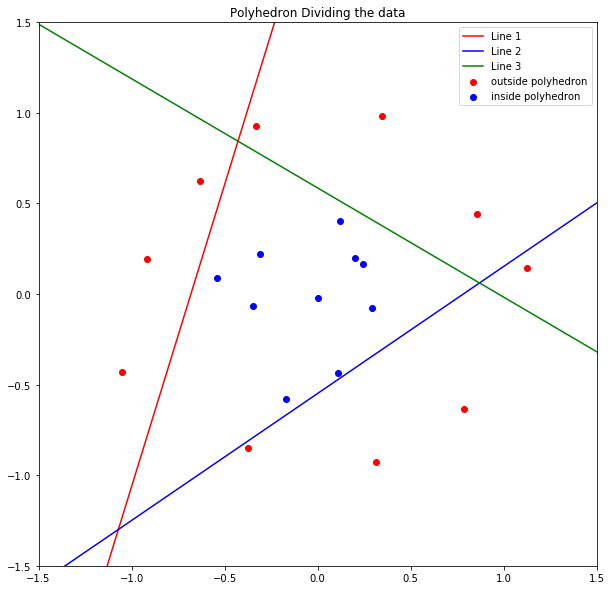

Number of Lines = 3



In [7]:
# Formulation A
class PolyhedronSolver(Polyhedron):
  def __init__(self):
    self.line_vals = []
    super(PolyhedronSolver,self).__init__()
    pass

  def plot(self):
      fig = plt.figure(figsize=(10,10))
      ax = fig.add_subplot(111)
      ax.scatter(self.S1[:,0],self.S1[:,1],c= "red", label = "outside polyhedron") # Plot S1
      ax.scatter(self.S2[:,0],self.S2[:,1],c= "blue", label = "inside polyhedron") # Plot S2

      get_color = ['', 'red', 'blue', 'green', 'yellow', 'orange', 'cyan', 'magenta', 'black', 'crimson', 'pink', 'purple', 'gold', 'olive', 'maroon', 'coral', 'violet', 'darkblue', 'gray', 'sienna', 'brown' ]
      x = np.linspace(-2.5, 2.5, 1000)
      count = 0
      for line in self.line_vals:
          count += 1
          m = -line[0] / line[1]
          c = -line[2] / line[1]
          ax.plot(x, m * x + c, color = get_color[count], label = "Line " + str(count))

      ax.set_title("Polyhedron Dividing the data")
      plt.legend()
      try:
          plt.axis(ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5)))
      except:
          pass
      plt.show()
      print("Number of Lines = " + str(count) + "\n")

  def solve(self):
      MAX_VAL = 1000
      n_lines = 10
      epsilon = 1e-2

      centroid = (len(self.S1) * np.mean(self.S1, axis = 0) + len(self.S2) * np.mean(self.S2, axis = 0)) / (len(self.S1) + len(self.S2))
      
      A_x = []
      for a_index in range(0, n_lines):
          A_x.append(cp.Variable())
 
      A_y = []
      for a_index in range(0, n_lines):
          A_y.append(cp.Variable())
      
      B = []
      for b_index in range(0, n_lines):
          B.append(cp.Variable())
 
      size = len(self.S1)
      Y = []
      
      for iterator in range(size):
          Y.append(cp.Variable(n_lines, boolean=True))
      
      delta = cp.Variable(len(self.S2), boolean=True)

      objective = cp.Minimize(cp.sum(delta[:]))
      
      # defining constraints
      constraints = []
      constraints.append(delta >= 0)
      
      for idx in range(n_lines):
          s_index = 0
          for s in self.S2:
              # inside points
              constraints.append(A_x[idx] * s[0] + A_y[idx] * s[1] + B[idx] <=  MAX_VAL * delta[s_index] - epsilon)
              s_index += 1
      
      for s_idx in range(size):
          constraints.append(cp.sum(Y[s_idx][:]) <= (n_lines - 1))
 
      for line_id in range(n_lines):
          for s_idx in range(size):
              # outside points
              constraints.append((A_x[line_id] * self.S1[s_idx][0] + A_y[line_id] * self.S1[s_idx][1] + B[line_id]) >= (epsilon - Y[s_idx][line_id] * MAX_VAL))
 
      problem = cp.Problem(objective, constraints)
      print("About to Solve...")

      problem.solve(solver=cp.ECOS_BB)
      print("Problem Solution Status:", problem.status)
      self.line_vals = []

      if problem.status.startswith("optimal") == False:
          print("The Solver did not find a solution.")
          return []
      
      print("Value of Slack:", delta.value)
      for idx in range(20):
          dist = 1e20
          try:
              dist = np.abs(A_x[idx].value * centroid[0] + A_y[idx].value * centroid[1] + B[idx].value) / np.sqrt(A_x[idx].value ** 2 + A_y[idx].value ** 2)
          except:
              pass
          finally:
              if dist < 2.12:
                  self.line_vals.append([A_x[idx].value, A_y[idx].value, B[idx].value])

      return self.line_vals 
 
solver = PolyhedronSolver()
solver.solve()
solver.plot()

# *Formulation*
---

$Let\ B\ be\ a\ bucket\ initially\ having\ all\ points\ in\ S_2$

$Let\ lines\ =\ 0$

$Let\ L\ =\ \{\}$

<b>

---

$Algorithm:$

$while\ |B|\ \gt\ 0\ and\ lines\ \lt\ 20:$
  
$\quad let\ direction\ =\ 1$

$\quad y_i(s)\ are\ our\ binary\ variables,\ \forall\ i=1(1)|B|$

$\quad Optimize\ the\ following\ LPP:$

$\quad Minimize\ \sum_{i=1}^{|B|}y_i$

$ \quad Subject\ to$

- $y_i\in[0, 1],\ \forall\ i=1(1)|B|$
- $(direction * (m.q_x^i - q_y^i + c) \le -\epsilon),\quad \forall\ i=1(1)|S_2|$
- $(direction * (m.p_x^i - p_y^i + c) \ge \epsilon -y_i.M),\quad \forall\ i=1(1)|B|$

$\quad if\ optimal\ solution\ is\ not\ found,\ update\ direction\ to\ (direction * 1)\ and\ re-run,\ $

$\quad \quad if\ it\ still\ fails,\ STOP$

$\quad remove\ (p_x^i, p_y^i)\ from\ B\ if\ y_i^*=0, \forall\ i=1(1)|B|$

$\quad if\ no\ points\ get\ removed,\ \ update\ direction\ to\ (direction * 1)\ and\ re-run,\ $

$\quad \quad if\ it\ fails\ to\ find\ a\ solution,\ or\ does\ not\ update\ B,\ STOP$

---

<b>

$Here,\ we\ use\ a\ set\ of\ LPs.$

$The\ set\ of\ lines\ forms\ the\ polygon.$

<b>

$M\ is\ a\ large\ value.$

$Other\ symbols\ have\ same\ meaning\ as\ Formulation\ A$

---

In [8]:
# Formulation B
class Polyhedron_B():
  def __init__(self):
    super(Polyhedron_B,self).__init__()
    data, labels = make_circles(n_samples=100, noise=0.15,factor=0.3) # This will create our data
    self.S1 = data[labels==0] # Points outside the polyhedron
    self.S2 = data[labels==1] # Points intside the polyhedron

Number of Unhandled Outer Points = 50
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 32
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 19
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 13
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 13
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 1
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 1
Status of Last Attempt : optimal
Number of Unhandled Outer Points = 1
Status of Last Attempt : optimal


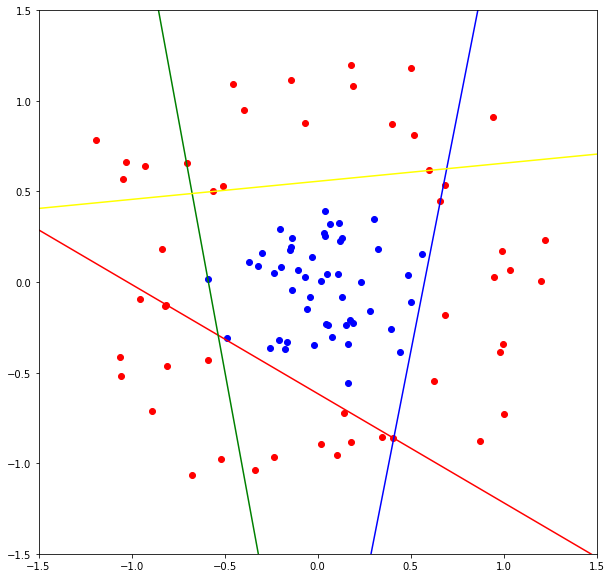

In [9]:
# N_lines LPPs
class PolyhedronSolver_B(Polyhedron_B):
  def __init__(self):
    self.line_vals = []
    self.polygon = None
    self.line_vals = []
    super(PolyhedronSolver_B,self).__init__()
    pass

  def plot(self):
      fig = plt.figure(figsize=(10, 10))
      ax = fig.add_subplot(111)
      ax.scatter(self.S1[:,0],self.S1[:,1],c= "red", label = "outside polyhedron") # Plot S1
      ax.scatter(self.S2[:,0],self.S2[:,1],c= "blue", label = "inside polyhedron") # Plot S2

      # Uncomment the lines to visualize the polygon
      # if self.polygon is not None:
      #     ax.plot(self.polygon[:,0],self.polygon[:,1],linewidth=3,c="black") # Plot the points
      #     ax.plot([self.polygon[0,0],self.polygon[-1,0]],[self.polygon[0,1],self.polygon[-1,1]],linewidth = 3,c = "black") # Plot the edges

      get_color = ['', 'red', 'blue', 'green', 'yellow', 'orange', 'cyan', 'magenta', 'black', 'crimson', 'pink', 'purple', 'gold', 'olive', 'maroon', 'coral', 'violet', 'darkblue', 'gray', 'sienna', 'brown' ]
      x = np.linspace(-1.5,1.5,1000)
      count = 0

      if self.line_vals != []:
          for line in self.line_vals:
              count += 1
              m = line[0]
              c = line[1]
              ax.plot(x, m * x + c, color = get_color[count], label = "Line " + str(count))

      try:
          plt.axis(ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5)))
      except:
          pass
      plt.show()

  def solve(self):
      MAX_VAL = 10
      S1_copy = [self.S1[i] for i in range(len(self.S1))]
      epsilon = 1e-3
      n_lines = 0 # minimum = 3
      n_line_max = 20
      final_slopes = []
      C = []

      direction = 1
      done = 0

      while len(S1_copy) > 0 and n_lines < n_line_max:
          print("Number of Unhandled Outer Points = " + str(len(S1_copy)))
          c = cp.Variable()
          slope = cp.Variable()
          y = cp.Variable(len(S1_copy), integer = True)

          objective = cp.Minimize(cp.sum(y[:]))
          
          constraints = [(y >= 0), (y <= 1)]
          
          for s in self.S2:
              # inside points
              constraints.append(direction * (slope * s[0] - s[1] + c) <= - epsilon)
          
          count = 0
          for s in S1_copy:
              constraints.append(direction * (slope * s[0] - s[1] + c) >= epsilon - y[count] * MAX_VAL)
              count += 1

          problem = cp.Problem(objective, constraints)
          problem.solve(solver=cp.GLPK_MI)
          print("Status of Last Attempt :", problem.status)

          if problem.status.startswith('optimal') == False and done < 2:
              direction *= -1
              done += 1
              continue

          elif problem.status.startswith('optimal') == False and done >= 2:
              break 

          flag = 0
          idx = len(S1_copy) - 1
          while idx > 0:
              if y.value[idx] < 0.001:
                  flag = 1
                  S1_copy.pop(idx)
              idx -= 1

          if flag == 1:
              done = 0
              C.append(c.value)
              final_slopes.append(slope.value)
              n_lines += 1
              continue

          elif problem.status.startswith('optimal') == False or flag == 0 and done < 2:
              direction *= -1
              done += 1
              continue
          
          elif done >= 2:
              break
              # infeasible
      
      found_lines = len(C)
      vertices = []
      for i in range(found_lines):
          m1 = final_slopes[i]
          m2 = final_slopes[(i + 1) % found_lines]
          c1 = C[i]
          c2 = C[(i + 1) % found_lines]
          x_point = (c2 - c1) / (m1 - m2)
          y_point = (m1 * c2 - m2 * c1) / (m1 - m2)
          vertices.append([x_point, y_point])
          self.line_vals.append([final_slopes[i], C[i]])

      if vertices != []:
          self.polygon = np.array(vertices)
      return vertices

solver = PolyhedronSolver_B()
solver.solve()
solver.plot()

## Largest Ball in a Polyhedron

Find the largest ball 
$$ B(x_c, R) = \{ x :  ||x − x_c|| ≤ R \}$$
enclosed in a given polyhedron
$$ P = \{ x | a_i^T x ≤ b_i, i = 1, . . . , m\} $$

- The problem variables are the center x<sub>c</sub> ∈ R<sub>n</sub> and the radius R of the ball.

- The class `CircleSolver` inherits the `CircleInPolygon` class. Function `plot` is used to plot the polyhedron and the circle. Function `solve` accepts the polyhedron as the input and returns the solution as a tuple (`center`, `radius`); where `center` is a $1 \times 2$ numpy array containing the center of the circle, and the `radius` is a scalar value.

In [10]:
class CircleInPolygon():
  def __init__(self):
     super(CircleInPolygon,self).__init__()
     self.polygon = np.random.random((10,2))
     self.polygon = self.polygon[ConvexHull(self.polygon).vertices,:]
     # polygon is stored here

# *Formulation*

---

$Maximize$ $R$

$Subject\ to$

- $|$ $a_ix$ $+$ $b_iy$ $+$ $c$ $|$ $\ge$ $\sqrt{a_i ^ 2 + b_i ^ 2}.R$ $,$
$ \forall$ $i$ $=$ $1$ $(1)$ $|V|$

$where$ $V$ $is$ $the$ $set$ $of$ $vertices,$
$a_ix$ $+$ $b_iy$ $+$ $c$ $ $ $is$ $the$ $equation$ $of$ $the$ $line$ $connecting$ $v_i$ $with$ $v_{i+1}$

$v_i$ $\in$ $V,$ $ $ $\forall$ $i$ $=$ $1$ $(1)$ $|V|$

---

Solution Attempt Status: optimal
Centre: [0.51779931 0.57937672]
Radius: [0.30524303]


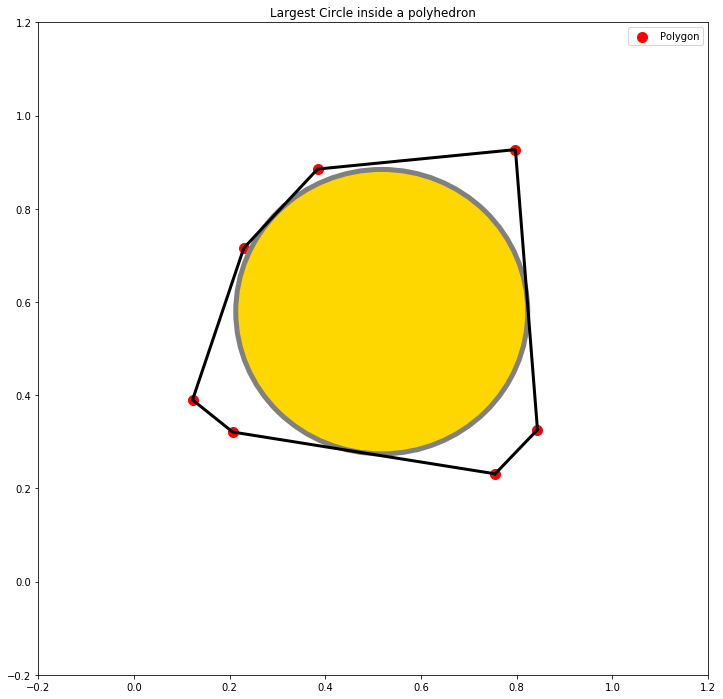

In [11]:
class CircleSolver(CircleInPolygon):
  def __init__(self):
     super(CircleSolver,self).__init__()


  def plot(self):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    ax.plot(self.polygon[:,0], self.polygon[:,1], linewidth = 3, c = "black") # Plot the points
    ax.plot([self.polygon[0,0], self.polygon[-1,0]],[self.polygon[0,1], self.polygon[-1,1]], linewidth = 3, c = "black") # Plotting the edges
    ax.scatter(self.polygon[:,0], self.polygon[:,1], s = 100, c = "red", label = "Polygon") # Plot the edge connecting the last and the first point

    circle = plt.Circle(self.c, self.R[0], facecolor="gold",edgecolor='gray',linewidth='5')
    ax.set_title("Largest Circle inside a polyhedron")
    ax.add_artist(circle)
    plt.legend()
    try:
        plt.axis(ax.set(xlim=(-0.2, 1.2), ylim=(-0.2, 1.2)))
    except:
        pass
    plt.show()

  def solve(self):
    size = len(self.polygon)
    R = cp.Variable(1)
    centre = cp.Variable(2)
    polygon_centre = np.mean(np.array(self.polygon),axis = 0)

    # Defining the Objective
    objective = cp.Maximize(R)
    
    # Defining the Constraints
    constraints = []
    
    A_B = []
    C = []
    for vertex_id in range(size):
        y_1 = self.polygon[vertex_id,1]
        y_2 = self.polygon[(vertex_id + 1) % size, 1]
        x_1 = self.polygon[vertex_id,0]
        x_2 = self.polygon[(vertex_id + 1) % size, 0]

        a = y_2 - y_1
        b = x_1 - x_2
        c = - x_1 * (y_2 - y_1) + y_1 * (x_2 - x_1)

        if (a * polygon_centre[0] + b * polygon_centre[1] + c) < 0:
            a *= -1
            b *= -1
            c *= -1

        A_B.append([a, b])
        C.append(c)
    
    for idx in range(size):
        dist = (A_B[idx][0] * centre[0] +  A_B[idx][1] * centre[1] + C[idx]) / np.sqrt(A_B[idx][0] ** 2 + A_B[idx][1] ** 2)
        constraints.append(dist >= R)
      
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS_BB)
    print("Solution Attempt Status:", problem.status)
    print("Centre:", centre.value)
    print("Radius:", R.value)
    
    self.R = R.value
    self.c = centre.value
    
    pass

solver = CircleSolver()
solver.solve()
solver.plot()

## Illumination Problem 


We consider an illumination system of m lamps, at positions l<sub>1</sub>, . . . , l<sub>m</sub> ∈ R<sup>2</sup>, illuminating n flat patches. 
The patches are line segments; the $i^{th}$ patch is given by: [v<sub>i</sub>, v<sub>i+1</sub>], where v<sub>1</sub>, . . . , v<sub>n+1</sub> ∈ R<sup>2</sup>. The variables in the problem are the lamp powers p<sub>1</sub>, . . . , p<sub>m</sub> which can vary between 0 and 1.
The illumination at the midpoint of the $i^{th}$ patch is denoted *I<sub>i</sub>*. We will use a simple model for illumination:


   $$I_i = \sum_{j=1}^m a_{ij}p_{j} $$
   $$ a_{ij} = r_{ij} ^{−2} ( max(cos θ_{ij},0) )$$

where r<sub>ij</sub> denotes the distance between lamp j and the midpoint of patch i, and θ<sub>ij</sub> denotes the angle between the upward normal of patch i and the vector from the midpoint of patch i to lamp j. 

![alt text](https://drive.google.com/uc?id=1ZyHm9hmKKZRvLryNkiixTEMTCxZts0qH)

This model takes into account “self-shading” i.e. the fact that a patch is illuminated only by lamps in the halfspace it faces but no shading of one patch due to another. We could use a more complex illumination model including shading and even reflections which would just change the matrix relating the lamp powers to the patch illumination levels.

The problem is to determine lamp powers that make the illumination levels close to a given desired illumination level I<sub>des</sub>, subject to the power limits 0 ≤ p<sub>i</sub> ≤ 1.

We use the maximum deviation:

####   $ φ(p) = max_{k=1,...,n} |I_{k} − I_{des}| $

as a measure for the deviation from the desired illumination level. 

We formulate the illumination problem using this criterion as a linear programming problem. The `Illumination` class creates the data and the `IlluminationSolver` class finds the optimal solution.

The elements of A are the coefficients a<sub>ij</sub> in the above equation. We can now compute a feasible p using this first method and then calculate φ(p).


In [12]:
class Illumination():
  def __init__(self):
    super(Illumination,self).__init__()

    self.Lamps = np.array([[0.1 ,0.3, 0.4, 0.6 ,0.8 ,0.9 ,0.95],[1.0, 1.1, 0.6 ,0.9, 0.9 ,1.2, 1.00]])
    # lamp positions
    self.m = self.Lamps.shape[1]
    # number of lamps

    # beginning and endpoints of patches  
    self.patches = [np.arange(0,1,1/12),np.array([0, 0.1, 0.2, 0.2, 0.1, 0.2, 0.3, 0.2, 0, 0, 0.2, 0.1])]
    self.patches = np.array(self.patches)
    self.n = self.patches.shape[1] - 1  # number of patches

    # desired illumination
    Ides = 2;

    # constructing A
    self.dpatches = self.patches[:,1:] - self.patches[:,:-1];
    # tangents to patches
    self.patches_mid = self.patches[:,1:] - 0.5*self.dpatches;
    # midpoints of patches
    A = np.zeros((self.n,self.m));
    for i in range(self.n):
      for j in range(self.m):
        dVI = self.Lamps[:, j] - self.patches_mid[:, i]
        # finding the distance between each lamp and patch 
        rij = np.linalg.norm(dVI, ord = 2)
        # Find the radius / distance between the lamp and the midpoint of the patch 
        normal = null_space(self.dpatches[:,i].reshape(1,2))
        # finding the normal

        if normal[1] < 0:
          # upward pointing normal  
          normal = -1 * normal
        A[i,j] = dVI.dot(normal)/(np.linalg.norm(dVI,ord=2)*np.linalg.norm(normal,ord=2))/(rij**2); # Find A[i,j] as defined above
        if A[i,j] < 0: 
          A[i,j] = 0

    self.A = A

# *Formulation*

---

$Minimize$ $ $ $max$ $|$ $A$ $P$ $-$ $I_{des}$ $|$

$Subject\ to:$

$0$ $\le$ $p_i$ $\le$ $1$ $\forall$ $i$ $=$ $1$ $(1)$ $m$ 

$where$ $A$ $=$ $(a_{ij})$ $and$ $P$ $\in$ $\mathbb{R}^m$

---


Optimal P:  [1.0, 0.6637006119548104, 0.0, 0.0, 0.0, 0.2652174699015724, 1.0]
Psi(P_optimal) =  1.0910372833138409


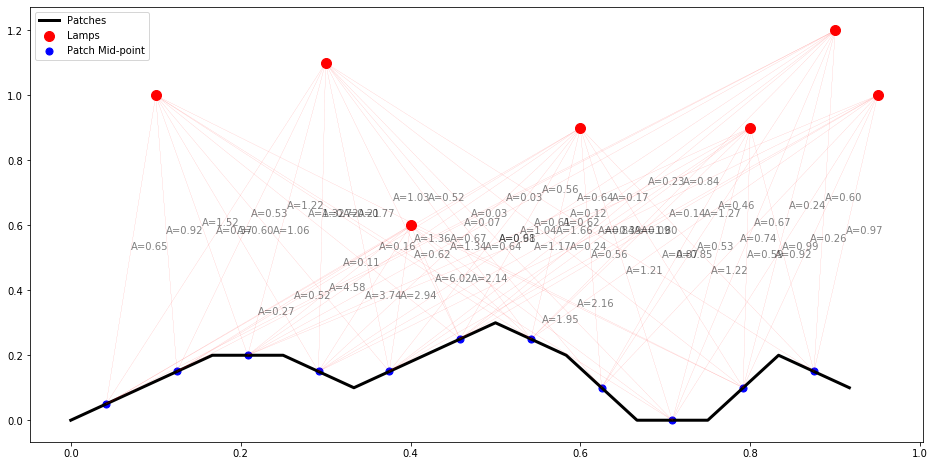

In [13]:
class IlluminationSolver(Illumination):
  def __init__(self):
    super(IlluminationSolver,self).__init__()

  def plot(self):
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
     
    ax.scatter(self.Lamps[0,:],self.Lamps[1,:],s=100,c="red",label="Lamps") # Lamps
    ax.scatter(self.patches_mid[0,:],self.patches_mid[1,:],s=50,c="blue",label="Patch Mid-point") # Lamps
    ax.plot(self.patches[0,:],self.patches[1,:],linewidth=3,c="black",label="Patches") # Patches

    # Normals joining lamps and patches 
    for i in range(self.n):
      for j in range(self.m):
        if self.A[i,j] > 0:
          ax.plot([self.Lamps[0,j], self.patches_mid[0,i]],[self.Lamps[1,j], self.patches_mid[1,i]],'r--',linewidth=0.1,alpha=1)
          ax.text((self.Lamps[0,j]+self.patches_mid[0,i])/2,(self.Lamps[1,j] + self.patches_mid[1,i])/2,"A={0:.2f}".format(self.A[i,j]),alpha=0.5)

    plt.legend()
    plt.show()
  
  def solve(self):
    P = cp.Variable(self.m)
    I = cp.matmul(self.A, P)
    I_des = 2 * np.ones(self.n)
    objective = cp.Minimize(cp.max(cp.abs(I - I_des)))
    constraints = [P >= 0, P <= 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver = cp.GLPK_MI)

    optimal_P = [i for i in P.value]
    print("Optimal P: ", optimal_P)
    print("Psi(P_optimal) = ", np.max(np.matmul(self.A, P.value) - I_des))   
    pass

solver = IlluminationSolver()
solver.solve()
solver.plot()


## Jigsaw Puzzle

Solving jigsaw puzzles computationally remains a relevant and intriguing problem. 

We implement a solver here that solves jigsaw puzzles using linear programming following the approach outlined in [Solving Jigsaw Puzzles with Linear Programming](https://arxiv.org/abs/1511.04472).

The current problem setting requires us to only solve Type $I$ problems (i.e. problems where the orientation of the pieces is known).

![alt text](https://drive.google.com/uc?id=19MyWwH6XV4jz244E5yBJAH0baZAXddVx)

- The `Jigsaw` class takes an image as input and creates a random jigsaw puzzle. Function `patches2image` reconstructs the image back from the patches.

- The class `JigsawSolver` inherits the `Jigsaw` class. Function `solve` accepts a numpy array of shape `R x C x H x W x 3` as input, where R & C are the number of rows and columns in the jigsaw puzzle respectively and H, W are the heights and widths of each piece. The returned solution is in the form of a numpy array of shape `R x C x H x W x 3`.

In [14]:
class Jigsaw():
  def __init__(self,path=None):
    super(Jigsaw,self).__init__()
    if path is None:
      with cbook.get_sample_data('grace_hopper.png') as image_file:
        self.image = plt.imread(image_file)
    else:
      self.image = plt.imread(path)

    self.original_size = self.image.shape[0: 2]
    self.new_size = (500, 500)
    self.rows = 5
    self.cols = 5

    # R x C x H x W x 3 numpy array storing the jigsaw puzzle
    self.jigsaw = self.create_jigsaw_puzzle(self.image,self.new_size,self.rows,self.cols)
  
  def image2patches(self,image,new_size,rows,cols):
    image = resize(image,self.new_size)
    patches = np.zeros((self.rows,self.cols,self.new_size[0] // self.rows, self.new_size[1] // self.cols,3))
    for i in range(self.rows):
      for j in range(self.cols):
        patches[i, j, :, :, :] = self.image[i * self.new_size[0] // self.rows:(i + 1) * self.new_size[0] // self.rows, j * self.new_size[0] // self.cols:(j + 1) * self.new_size[0] // self.cols, :]
    return patches 

  def patches2image(self,patches,original_size):
    R,C,H,W,_ = patches.shape
    image = np.zeros((R*H,C*W,3))
    for i in range(R):
      for j in range(C):
        image[i * H: (i + 1) * H, j * W: (j + 1) * W, :] = patches[i, j, :, :, :] 
    
    image = resize(image,original_size) 
    return image 

  def create_jigsaw_puzzle(self, image, new_size, rows, cols):
    patches = self.image2patches(image, new_size, rows, cols)
    R, C, H, W, _ = patches.shape
    patches = patches.reshape((-1, H, W, 3))
    patches = patches[np.random.permutation(R * C),...].reshape((R, C, H, W, 3))
    return patches

# *Formulation*

---

$Let\ D_{ijo}$ $=$ $Mahalanobis-Gradient-Compatability$ $(piece_i,$ $ $ $piece_j,$ $ $ $o),$ $ $ $piece_i$ $is$ $a$ $piece$ $of$ $the$ $jigsaw,$ $\forall$ $i$ $=$ $1$ $(1)$ $|piece|$

<br>

$Define:$

\begin{equation}
\delta_o^x = \begin{cases}
0 & \text{if $o$ $=$ $1$}\\
-1 & \text{if $o$ $=$ $2$}\\
0 & \text{if $o$ $=$ $3$}\\
1 & \text{if $o$ $=$ $4$}
\end{cases}
\end{equation}

\begin{equation}
\delta_o^y = \begin{cases}
1 & \text{if $o$ $=$ $1$}\\
0 & \text{if $o$ $=$ $2$}\\
-1 & \text{if $o$ $=$ $3$}\\
0 & \text{if $o$ $=$ $4$}
\end{cases}
\end{equation}

<br>

$$\displaystyle w_{ijo} = \frac {min(min_{k \ne i} (D_{kjo}), min_{k \ne j} (D_{iko}))} {D_{ijo}}$$

<br>

$$\displaystyle A = \{ (i, j, o) \in U: j = \underset{j:(i, j, o) \in U}{\operatorname{argmin}} D_{ijo}\} $$

<br>

$where$ $U$ $is$ $the$ $set$ $of$ $all$ $(i, j, o)$ $ $ $s.t$  $ $ $i$ $=$ $1$ $(1)$ $|piece|,$ $ $ $j$ $=$ $1$ $(1)$ $|piece|,$ $ $ $o$ $\in$ $[1, 2, 3, 4]$

$Let$ $x,$ $ $ $y,$ $and$ $h$ $be$ $our$ $optimization$ $variables$

$(y_i,$ $x_i)$ $denotes$ $the$ $position$ $where$ $piece_i$ $should$ $go;$ $(0, 0)$ $being$ $the$ $image$ $centre$

---

$Our$ $LP$ $Formulation$ $is$ $therefore:$

<br>

$$\displaystyle \underset{(x, y, h)}{Minimize} \underset{(i, j, o) \in A}\sum w_{ijo}.h_{ijo} + 
\underset{(i, j, o) \in A}\sum w_{ijo}.h'_{ijo}$$

$$subject\,to:$$

$$\displaystyle h_{ijo} \ge x_i - x_j - \delta_o^x,\ \ \forall (i, j, o) \in A$$

$$\displaystyle h_{ijo} \ge -x_i + x_j + \delta_o^x,\ \ \forall (i, j, o) \in A$$

$$\displaystyle h'_{ijo} \ge y_i - y_j - \delta_o^y,\ \ \forall (i, j, o) \in A$$

$$\displaystyle h'_{ijo} \ge -y_i + y_j + \delta_o^y,\ \ \forall (i, j, o) \in A$$

<br>
$x^*$ $and$ $y^*$ $give$ $us$ $the$ $required$ $alignments$ $from$ $which$ $we$ $can$ $reconstruct$ $our$ $image.$

---


Status of Solution: optimal


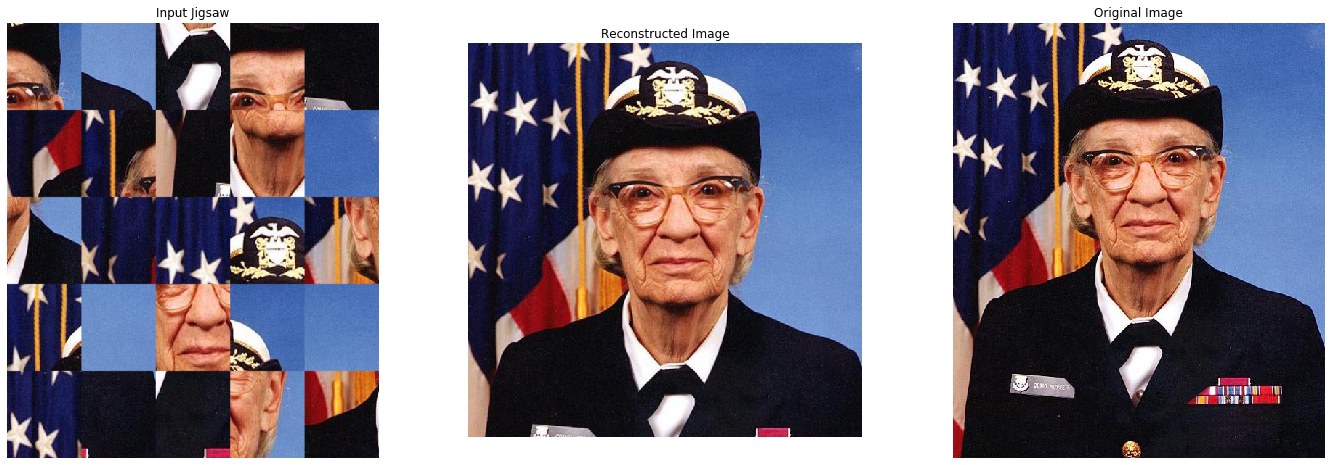

In [15]:
from scipy.spatial.distance import mahalanobis

class JigsawSolver(Jigsaw):
  def __init__(self,*args,**kwargs):
    super(JigsawSolver,self).__init__()
    self.solved_image = None
    pass

  def plot(self):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(131)
    ax1.imshow(self.patches2image(self.jigsaw,self.original_size))
    ax1.axis('off')
    ax1.set_title("Input Jigsaw")

    ax2 = fig.add_subplot(132)
    solution_size = (600, 600)
    ax2.imshow(self.patches2image(self.solved_image, solution_size))
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")

    ax3 = fig.add_subplot(133)
    ax3.imshow(self.image)
    ax3.axis('off')
    ax3.set_title("Original Image")

    plt.show()

  def solve(self):
    flattened = []
    N = self.jigsaw.shape[0]
    M = self.jigsaw.shape[1]
    for i in range(N):
        for j in range(M):
            flattened.append(self.jigsaw[i][j])

    D = np.zeros(shape = (N * M, N * M, 4))
    W = np.zeros(shape = (N * M, N * M, 4))
    
    for i in range(N * M):
        for j in range(N * M):
            for o in range(4):
                D[i, j, o] = self.mgc(flattened[i], flattened[j], o)

    for i in range(N * M):
        for j in range(N * M):
            for o in range(4):
                min_k_not_i = 1e20
                min_k_not_j = 1e20
                for k in range(N * M):
                    if k != i and min_k_not_i > D[k, j, o]:
                        min_k_not_i = D[k, j, o]

                    if k != j and min_k_not_j > D[i, k, o]:
                        min_k_not_j = D[i, k, o]
                
                        min_k_not_i = D[k, j, o]
                W[i, j, o] = min(min_k_not_i, min_k_not_j) / D[i, j, o]

    delta_x = [0, -1, 0, 1]
    delta_y = [1, 0, -1, 0]

    U = []
    for i in range(N * M):
        for j in range(N * M):
            for o in range(4):
                U.append([i, j, o])

    A = []
    for i in range(N * M):
        for o in range(4):
            min_val = 1e20
            min_arg = 0

            for u in U:
                if u[0] == i and u[2] == o and D[i, u[1], o] < min_val:
                    min_val = D[i, u[1], o]
                    min_arg = u[1]

            A.append([i, min_arg, o])

    # Constructing the LP
    x = cp.Variable(N * M)
    y = cp.Variable(N * M)
    h_x = cp.Variable(len(A))
    h_y = cp.Variable(len(A))

    # Objective
    obj_sum = 0

    # Constraints
    constraints = []

    index = 0

    for a in A:
        obj_sum += (W[a[0], a[1], a[2]] * (h_x[index] + h_y[index]))
        # for x
        constraints.append(h_x[index] >= x[a[0]] - x[a[1]] - delta_x[a[2]])
        constraints.append(h_x[index] >= -x[a[0]] + x[a[1]] + delta_x[a[2]])
        # for y
        constraints.append(h_y[index] >= y[a[0]] - y[a[1]] - delta_y[a[2]])
        constraints.append(h_y[index] >= -y[a[0]] + y[a[1]] + delta_y[a[2]])
        index += 1

    objective = cp.Minimize(obj_sum)
    problem = cp.Problem(objective, constraints)
    problem.solve()
    print("Status of Solution:", problem.status)

    X = np.round(x.value) + np.max(np.round(x.value)) # column
    Y = np.round(y.value) + np.max(np.round(y.value)) # row

    # Compute the Solved Image
    solved = np.array(self.jigsaw, copy=True)
    for index in range(len(X)):
        solved[int(Y[index]), int(X[index])] = flattened[index]

    self.solved_image = solved
    pass

  def mgc(self, image1, image2, orientation):
    # Author: https://github.com/mhmoed 
    # Source: https://github.com/mhmoed/jigsaw/blob/33f16a6cb4870bd21f249b7d0444368a271a082f/jigsaw/linprog.py#L346
    '''
    Calculate the Mahalanobis Gradient Compatibility (MGC) of image 1 relative
    to image 2. MGC provides a measure of the similarity in gradient
    distributions between the boundaries of adjoining images with respect to
    a particular orientation. For detailed information on the underlying,
    please see Gallagher et al. (2012).
    Orientations are integers, defined according to Yu et al. (2015):
    - 0: measure MGC between the top of image 1 and bottom of image 2;
    - 1: measure MGC between the right of image 1 and left of image 2;
    - 2: measure MGC between the bottom of image 1 and top of image 2;
    - 3: measure MGC between the left of image 1 and right of image 2;
    Both images are first rotated into position according to the specified
    orientations, such that the right side of image 1 and the left side of
    image 2 are the boundaries of interest. This preprocessing step simplifies
    the subsequent calculation of the MGC, but increases computation time.
    Therefore, a straightforward optimisation would be to extract boundary
    sequences directly.
    NOTE: nomenclature taken from Gallagher et al. (2012).
    :param orientation: orientation image 1 relative to image 2.
    :param image1: first image.
    :param image2: second image.
    :return MGC.
    '''
    NUM_CONSTRAINTS = 2
    # Threshold after which to reject a match from the LP solution
    MATCH_REJECTION_THRESHOLD = 10e-5
    # Delta functions for inequality constraints
    DELTA_X = [0, -1, 0, 1]
    DELTA_Y = [1, 0, -1, 0]
    # Number of rotations to align pieces for MGC calculation
    MGC_NUM_ROTATIONS = [3, 0, 1, 2]
    # Number of possible orientations for two pieces

    MGC_NUM_ORIENTATIONS = len(MGC_NUM_ROTATIONS)
    assert image1.shape == image2.shape, 'images must be of same dimensions'
    assert orientation in MGC_NUM_ROTATIONS, 'invalid orientation'

    num_rotations = MGC_NUM_ROTATIONS[orientation]

    # Rotate images based on orientation - this is easier than extracting
    # the sequences based on an orientation case switch

    image1_signed = np.rot90(image1, num_rotations).astype(np.float64)
    image2_signed = np.rot90(image2, num_rotations).astype(np.float64)

    # Get mean gradient of image1

    g_i_l = image1_signed[:, -1] - image1_signed[:, -2]
    mu = g_i_l.mean(axis=0)

    # Get covariance matrix S
    # Small values are added to the diagonal of S to resolve non-invertibility
    # of S. This will not influence the final result.

    s = np.cov(g_i_l.T) + np.eye(3) * 10e-6

    # Get G_ij_LR

    g_ij_lr = image2_signed[:, 1] - image1_signed[:, -1]

    return sum(mahalanobis(row, mu, np.linalg.inv(s)) for row in g_ij_lr)

solver = JigsawSolver(path = None)
solver.solve()
solver.plot()

# $Thank\ You$

---